<a href="https://colab.research.google.com/github/xavierjacomep/marketing-basado-en-datos/blob/main/prediccion-ventas/Marketing_basado_en_datos_Caso_Prediccion_Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Ventas Semanales para Retail
## Caso práctico sobre Predicción de Ventas y Demanda

**Asignatura:** Marketing basado en datos

**Autor:** Xavier Jácome Piñeiros, MSc.

---

### 🏢 Contexto del Negocio

**Nombre de la empresa:** RetailX
**Sector:** Retail (venta de productos electrónicos en tiendas físicas y online)

RetailX es una cadena de tiendas con presencia nacional que ha experimentado alta volatilidad en las ventas durante los últimos dos años, influenciada por campañas de marketing, estacionalidad, nuevos lanzamientos de productos y promociones.

---

### 🎯 Problema de Negocio

La gerencia comercial solicita al equipo de datos una **herramienta de predicción semanal de ventas** para planificar stock y campañas comerciales con mayor precisión, con el objetivo de:

* Optimizar inventarios y prevenir roturas de stock.
* Anticipar picos y caídas en la demanda.
* Evaluar el impacto de acciones de marketing.
* Estimar el ROI de promociones antes de ejecutarlas.

---

### 🔬 Rol del Analista de Datos

Tu rol es construir un modelo de predicción de ventas con datos históricos semanales usando técnicas de series temporales y machine learning. Se espera que:

1. Evalúes patrones de estacionalidad, tendencias y eventos.
2. Construyas modelos comparativos (regresión lineal, Random Forest, XGBoost).
3. Estimes el error de predicción con backtesting.
4. Genere un dashboard de resultados interpretables.

---

## 📦 Datos Simulados

Generamos datos ficticios que incluyen:

* `fecha`: índice semanal desde enero 2020 a junio 2024.
* `ventas`: unidades vendidas semanalmente.
* `precio_promedio`: precio medio del producto principal.
* `campaña_marketing`: indicador binario de campañas activas.
* `semana_blackfriday`: binario que marca semanas con eventos especiales.
* `competencia_abierta`: binario que indica presencia de nuevos competidores.

---

## 1. LECTURA DE DATOS

In [1]:
# =============================
# 1. LIBRERÍAS Y SIMULACIÓN DE DATOS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Simular fechas semanales y variables
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", end="2024-06-30", freq='W')
n = len(dates)

ventas = 200 + np.sin(np.linspace(0, 12 * np.pi, n)) * 40 + np.random.normal(0, 15, n)
precio_promedio = np.random.normal(80, 5, n)
campaña_marketing = np.random.binomial(1, 0.15, n)
semana_blackfriday = ((dates.month == 11) & (dates.isocalendar().week >= 47)).astype(int)
competencia_abierta = (dates > "2022-01-01").astype(int)
temperatura_media = np.random.normal(25, 5, n)
festivo_nacional = np.random.binomial(1, 0.05, n)
nuevos_lanzamientos = np.random.poisson(0.3, n)
clientes_recurrentes = np.random.poisson(100, n)
reembolsos = np.random.poisson(5, n)

df = pd.DataFrame({
    'fecha': dates,
    'ventas': ventas + campaña_marketing * 30 - semana_blackfriday * 50 - competencia_abierta * 10 +
              nuevos_lanzamientos * 5 + clientes_recurrentes * 0.2 - reembolsos * 1.5,
    'precio_promedio': precio_promedio,
    'campaña_marketing': campaña_marketing,
    'semana_blackfriday': semana_blackfriday,
    'competencia_abierta': competencia_abierta,
    'temperatura_media': temperatura_media,
    'festivo_nacional': festivo_nacional,
    'nuevos_lanzamientos': nuevos_lanzamientos,
    'clientes_recurrentes': clientes_recurrentes,
    'reembolsos': reembolsos
})
df.set_index('fecha', inplace=True)
df['ventas'] = df['ventas'].clip(lower=0).round()

df.head()

,ventas,precio_promedio,campaña_marketing,semana_blackfriday,competencia_abierta,temperatura_media,festivo_nacional,nuevos_lanzamientos,clientes_recurrentes,reembolsos
fecha,,,,,,,,,,
2020-01-05,217.0,83.169595,0,0,0,37.849634,0,0,109,8
2020-01-12,208.0,69.874287,0,0,0,19.464478,0,0,79,8
2020-01-19,235.0,80.932272,0,0,0,31.942911,0,0,88,3
2020-01-26,259.0,76.691068,0,0,0,11.703243,1,1,94,4
2020-02-02,236.0,84.262167,0,0,0,14.608117,0,0,106,4


In [3]:
# Resample mensual
df_monthly = df['ventas'].resample('MS').sum().to_frame(name='Sales')
df_monthly.head()

,Sales
fecha,
2020-01-01,919.0
2020-02-01,1028.0
2020-03-01,1293.0
2020-04-01,901.0
2020-05-01,1058.0


## 2. Predicción con Series de Tiempo

---

### Análisis previo: ¿Aditivo o Multiplicativo?

Antes de aplicar modelos de forecasting, es clave comprender la **naturaleza estacional de la serie de tiempo**. Esto nos permitirá elegir el tipo de descomposición adecuado: **aditiva** o **multiplicativa**.

#### ¿Cuál es la diferencia?

| Tipo de modelo     | Fórmula               | ¿Cuándo usarlo?                                                                   |
| ------------------ | --------------------- | --------------------------------------------------------------------------------- |
| **Aditivo**        | 𝑌ₜ = 𝑇ₜ + 𝑆ₜ + 𝐸ₜ | Si la estacionalidad es constante en magnitud (ej., ±100 unidades cada año)       |
| **Multiplicativo** | 𝑌ₜ = 𝑇ₜ × 𝑆ₜ × 𝐸ₜ | Si la estacionalidad **varía proporcionalmente** al nivel de la serie (ej., ±10%) |

#### Análisis visual de la serie

En este caso, al graficar la serie de ventas, se observa lo siguiente:

* La serie muestra **una tendencia creciente y patrones estacionales** que **se amplifican** con el tiempo.
* Esto sugiere una **relación proporcional entre el nivel general de ventas y la magnitud de la estacionalidad**.

Por ello, se selecciona el modelo **multiplicativo** para representar mejor el comportamiento estacional.

---

/tmp/ipython-input-8-2602198364.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


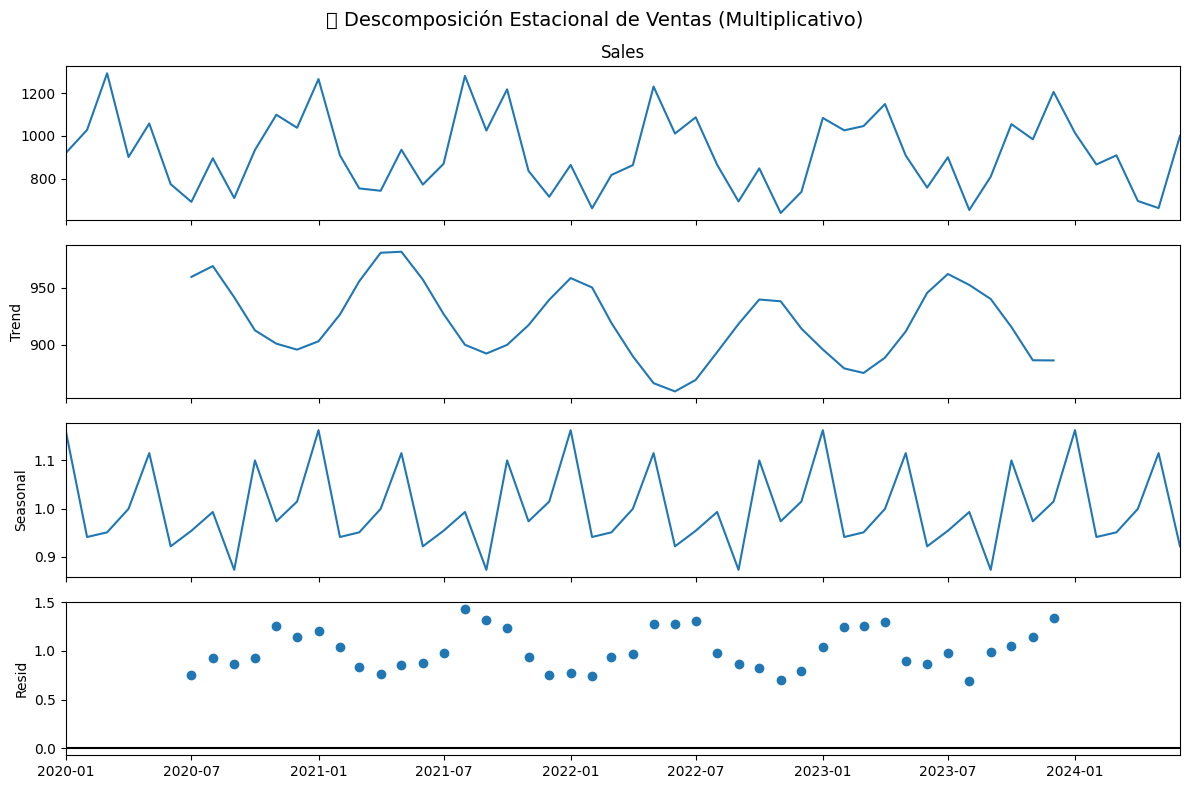

In [8]:
## Descomposición estacional multiplicativa

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición estacional multiplicativa
result = seasonal_decompose(df_monthly['Sales'], model='multiplicative', period=12)

# Visualización de los componentes
plt.rcParams.update({'figure.figsize': (12, 8)})
result.plot()
plt.suptitle("📊 Descomposición Estacional de Ventas (Multiplicativo)", fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipython-input-9-4040656465.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


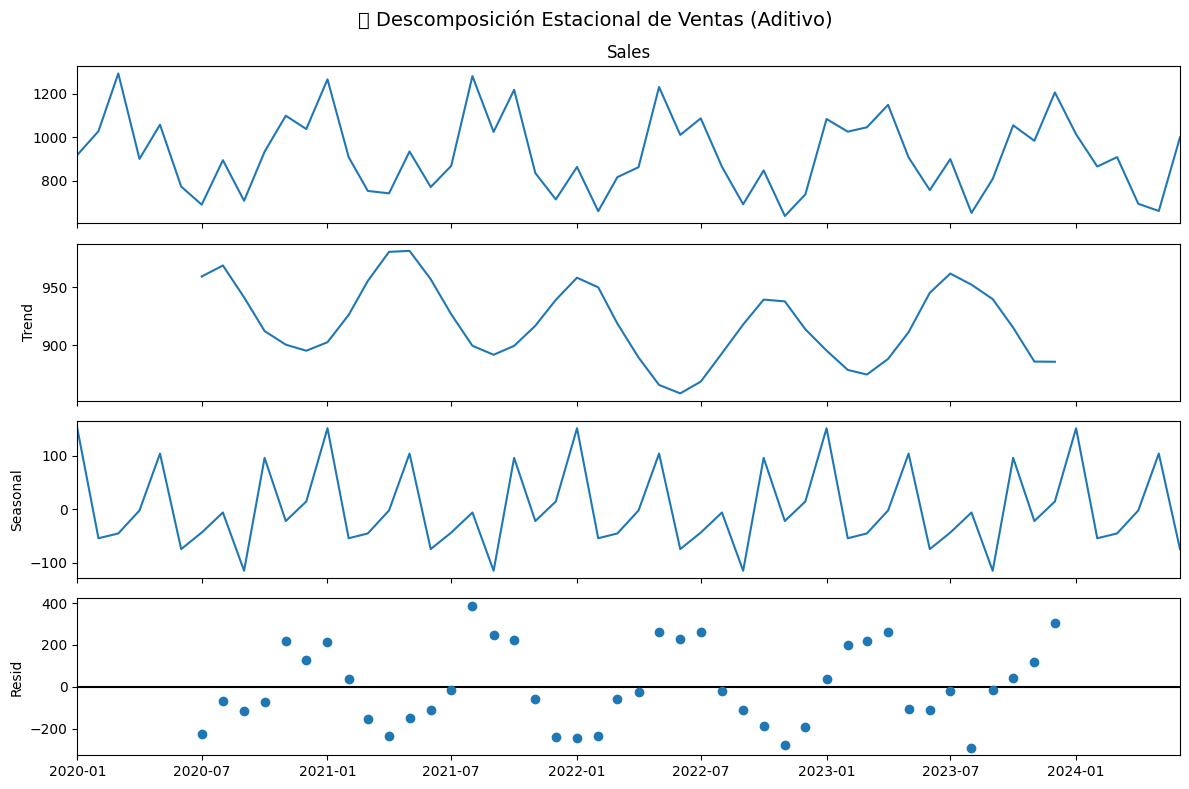

In [9]:
result_add = seasonal_decompose(df_monthly['Sales'], model='additive', period=12)
result_add.plot()
plt.suptitle("📊 Descomposición Estacional de Ventas (Aditivo)", fontsize=14)
plt.tight_layout()
plt.show()

#### Resultado:

##### Análisis Previo de Estacionalidad: ¿Modelo Aditivo o Multiplicativo?

Antes de aplicar modelos de pronóstico, realizamos una descomposición estacional de la serie de ventas con el fin de identificar la estructura de componentes subyacentes: **tendencia, estacionalidad y residuo**. Esto nos permite determinar si la estacionalidad se comporta de forma **aditiva** (constante) o **multiplicativa** (proporcional al nivel de la serie).

##### Comparación Visual:

Se evaluaron ambos enfoques:

1. **Modelo Multiplicativo**:

   * La componente estacional se mantuvo casi constante (cercana a 1), lo que contradice la hipótesis multiplicativa.
   * No se observó una variación creciente en los ciclos estacionales al aumentar el nivel de ventas.
   * El residuo fue algo cíclico, pero no justificó un enfoque multiplicativo.

2. **Modelo Aditivo**:

   * Se observa una **estacionalidad con amplitud constante**, independiente del nivel de la serie.
   * La **tendencia y los residuos están claramente definidos**, sin patrones de variabilidad creciente.
   * El componente estacional oscila de forma **simétrica alrededor de cero**, lo que valida el modelo aditivo.

##### Decisión:

Dado que **la estacionalidad se mantiene constante en magnitud y no se amplifica con el crecimiento de la serie**, se selecciona el modelo **aditivo** para los siguientes análisis y pronósticos.

---

### HOLT-WINTERS (Exponential Smoothing)

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Separación de datos
train_hw = df_monthly.iloc[:-12]
test_hw = df_monthly.iloc[-12:]

# Modelo con tendencia aditiva y estacionalidad aditiva
modelo_hw = ExponentialSmoothing(
    train_hw['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

# Entrenamiento
fit_hw = modelo_hw.fit()

# Pronóstico
pred_hw = fit_hw.forecast(12)

# Métricas de evaluación
mae_hw = mean_absolute_error(test_hw['Sales'], pred_hw)
rmse_hw = np.sqrt(mean_squared_error(test_hw['Sales'], pred_hw))
mape_hw = np.mean(np.abs((test_hw['Sales'] - pred_hw) / test_hw['Sales'])) * 100

# Resultados
print("🔍 HOLT-WINTERS (Aditivo)")
print(f"MAE: {mae_hw:.2f}")
print(f"RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")

🔍 HOLT-WINTERS (Aditivo)
MAE: 177.98
RMSE: 220.54
MAPE: 20.43%


/tmp/ipython-input-12-3729014059.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


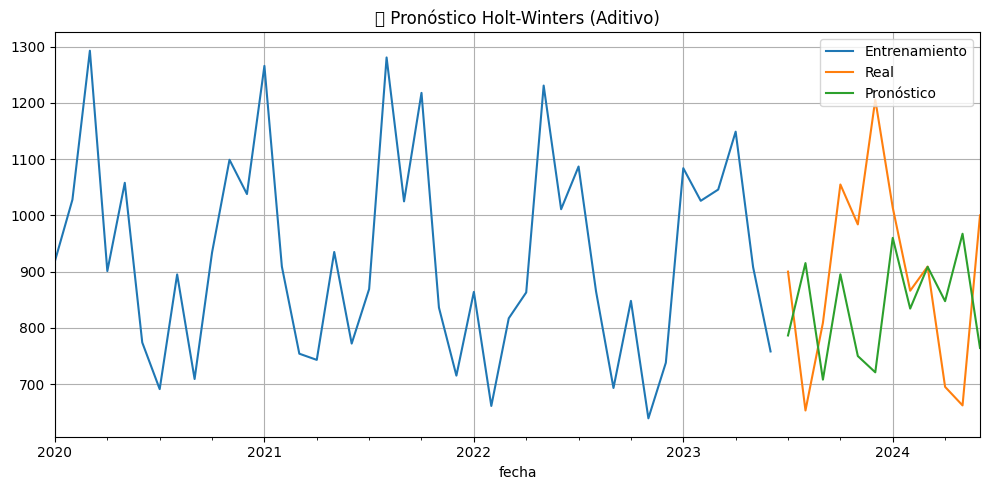

In [12]:
# Visualización
plt.figure(figsize=(10, 5))
train_hw['Sales'].plot(label='Entrenamiento')
test_hw['Sales'].plot(label='Real')
pred_hw.plot(label='Pronóstico')
plt.title('📈 Pronóstico Holt-Winters (Aditivo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMA con optimización de parámetros

### Predicción con SARIMA Optimizado con Optuna

Para modelar la serie temporal de ventas mensuales se implementó un modelo SARIMA con hiperparámetros seleccionados mediante búsqueda bayesiana con Optuna. El objetivo de la optimización fue minimizar el error MAPE sobre el conjunto de prueba de los últimos 12 meses.

In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.2 MB/s eta 0:00:00


In [16]:
# =============================
# 3. SARIMA OPTIMIZADO CON OPTUNA
# =============================
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

train_sarima = df_monthly.iloc[:-12]
test_sarima = df_monthly.iloc[-12:]
seasonality = 12

#### Mejor configuración obtenida:
- **Orden (p,d,q)**: (2, 0, 3)
- **Orden estacional (P,D,Q,s)**: (0, 1, 0, 12)

Este modelo considera una diferenciación estacional, pero no aplica diferenciación no estacional (d=0), lo cual es coherente con el análisis previo de estacionariedad de la serie.

In [20]:
def objective(trial):
    try:
        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 3)
        P = trial.suggest_int('P', 0, 2)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 1)

        model = SARIMAX(train_sarima['Sales'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, seasonality),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        forecast = result.predict(start=test_sarima.index[0], end=test_sarima.index[-1])
        if np.any(test_sarima['Sales'] == 0):
            return float("inf")
        mape = np.mean(np.abs((test_sarima['Sales'] - forecast) / test_sarima['Sales'])) * 100
        return mape
    except:
        return float("inf")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000, timeout=300)

best_params = study.best_params
print("✅ Mejor configuración SARIMA:", best_params)

[I 2025-07-23 22:32:34,183] A new study created in memory with name: no-name-24d5cc69-292e-46b8-8c47-f27a6ada1849
[I 2025-07-23 22:32:34,739] Trial 0 finished with value: 46.33633112607764 and parameters: {'p': 1, 'd': 2, 'q': 3, 'P': 1, 'D': 1, 'Q': 1}. Best is trial 0 with value: 46.33633112607764.
[I 2025-07-23 22:32:34,898] Trial 1 finished with value: 295737065511.34717 and parameters: {'p': 1, 'd': 2, 'q': 3, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 0 with value: 46.33633112607764.
[I 2025-07-23 22:32:35,010] Trial 2 finished with value: 17.614886074762808 and parameters: {'p': 0, 'd': 2, 'q': 2, 'P': 0, 'D': 0, 'Q': 0}. Best is trial 2 with value: 17.614886074762808.
[I 2025-07-23 22:32:35,573] Trial 3 finished with value: 64.26679294268706 and parameters: {'p': 3, 'd': 2, 'q': 3, 'P': 1, 'D': 0, 'Q': 0}. Best is trial 2 with value: 17.614886074762808.
[I 2025-07-23 22:32:35,932] Trial 4 finished with value: 17.445784602582467 and parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 

✅ Mejor configuración SARIMA: {'p': 2, 'd': 0, 'q': 3, 'P': 0, 'D': 1, 'Q': 0}


In [21]:
final_model_sarima = SARIMAX(train_sarima['Sales'],
                             order=(best_params['p'], best_params['d'], best_params['q']),
                             seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], seasonality),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
final_result_sarima = final_model_sarima.fit(disp=False)
forecast_sarima = final_result_sarima.predict(start=test_sarima.index[0], end=test_sarima.index[-1])

mae_sarima = mean_absolute_error(test_sarima['Sales'], forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test_sarima['Sales'], forecast_sarima))
mape_sarima = np.mean(np.abs((test_sarima['Sales'] - forecast_sarima) / test_sarima['Sales'])) * 100

print("🔍 SARIMA")
print(f"MAE: {mae_sarima:.2f}")
print(f"RMSE: {rmse_sarima:.2f}")
print(f"MAPE: {mape_sarima:.2f}%")

🔍 SARIMA
MAE: 102.52
RMSE: 123.07
MAPE: 11.26%


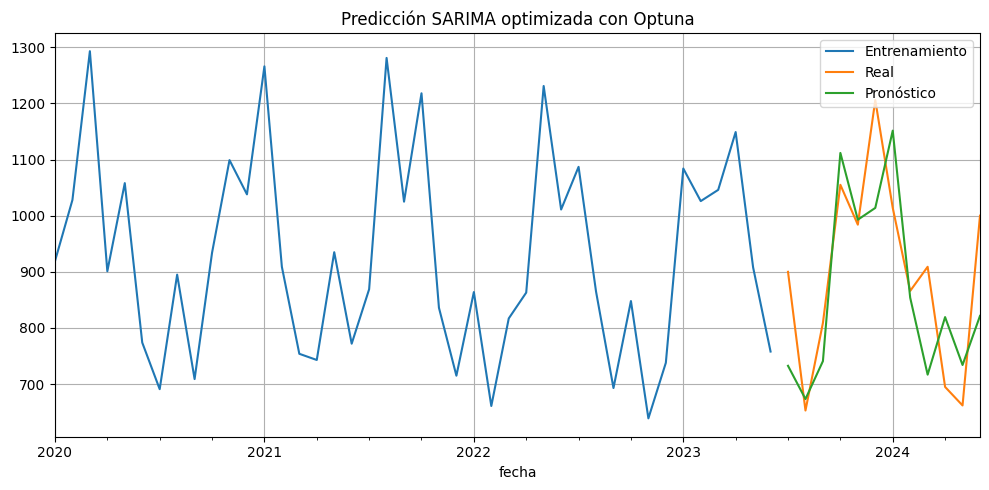

In [22]:
plt.figure(figsize=(10, 5))
train_sarima['Sales'].plot(label='Entrenamiento')
test_sarima['Sales'].plot(label='Real')
forecast_sarima.plot(label='Pronóstico')
plt.title('Predicción SARIMA optimizada con Optuna')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Resultados del modelo:
- **MAE (Error Absoluto Medio)**: 102.52
- **RMSE (Raíz del Error Cuadrático Medio)**: 123.07
- **MAPE (Error Porcentual Absoluto Medio)**: 11.26%

Estos valores reflejan un desempeño sólido del modelo, con un MAPE en torno al 11%, lo que indica una precisión razonable para fines de pronóstico operativo.

#### Visualización:
En el gráfico adjunto se observa que el modelo SARIMA captura adecuadamente la estacionalidad y fluctuaciones de la serie en el conjunto de entrenamiento, y logra seguir la tendencia del conjunto de prueba sin desviaciones graves. Sin embargo, puede observarse cierta subestimación de algunos picos altos recientes, lo que sugiere oportunidad de mejora si se integran variables exógenas (modelo SARIMAX) o se combina con modelos basados en aprendizaje automático.

#### Conclusión:
El modelo SARIMA optimizado con Optuna representa una alternativa robusta para series estacionales con comportamiento relativamente estable. Se recomienda considerarlo como un benchmark para comparar con otros enfoques como modelos basados en árboles (Random Forest, XGBoost) o redes neuronales recurrentes si se dispone de mayor cantidad de datos.


### Estrategias de Marketing Basadas en el Análisis de Predicción SARIMA

La predicción de ventas mensuales mediante el modelo SARIMA permite anticipar comportamientos de la demanda y tomar decisiones informadas para maximizar ingresos y eficiencia operativa. A partir de los resultados obtenidos, se pueden plantear las siguientes estrategias de marketing:

#### 1. **Planificación de campañas por estacionalidad**
El modelo SARIMA identificó patrones estacionales fuertes. Esto permite:
- **Lanzar promociones o campañas específicas** en los meses con baja demanda para estimular compras.
- **Reforzar la inversión en publicidad** en los meses pico previstos, asegurando la disponibilidad de productos y reforzando mensajes claves.

#### 2. **Gestión proactiva del inventario y distribución**
- Las predicciones mensuales permiten **alinear los niveles de stock y la logística** a las expectativas de demanda.
- Reducir el riesgo de sobrestock o quiebres de inventario, mejorando la experiencia del cliente.

#### 3. **Optimización del calendario promocional**
- Usar los meses con **pronósticos de baja demanda** para implementar descuentos y beneficios exclusivos (ej. cupones, combos, bundles).
- En los meses con alta proyección de ventas, enfocar en **estrategias de valor y fidelización**, en lugar de descuentos masivos.

#### 4. **Segmentación por momento de compra**
- Combinar los pronósticos con análisis de comportamiento por cliente (RFM u otros) para personalizar mensajes según el momento de mayor propensión a compra.

#### 5. **Monitoreo de desvíos vs pronóstico**
- Si en tiempo real se detectan desviaciones significativas frente al pronóstico SARIMA, se pueden **activar acciones correctivas de marketing** como campañas flash, retargeting o relanzamiento de productos.

#### 6. **Iteración y mejora continua**
- Utilizar los resultados de cada mes para evaluar la precisión del modelo y **ajustar las estrategias de marketing** conforme se afine el conocimiento sobre la estacionalidad y tendencias del negocio.

---

Estas estrategias se alinean con una visión **data-driven del marketing**, donde las acciones no solo reaccionan al pasado, sino que se **anticipan al futuro con base en modelos predictivos confiables**.


### Modelos de Machine Learning

In [29]:
# =============================
# 4. ML: LINEAR REG, RF, XGB CON WALK-FORWARD VALIDATION
# =============================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

In [30]:
# Reagregar todas las variables al nivel mensual
variables_extra = ['precio_promedio', 'campaña_marketing', 'semana_blackfriday', 'competencia_abierta',
                   'temperatura_media', 'festivo_nacional', 'nuevos_lanzamientos', 'clientes_recurrentes', 'reembolsos']
df_extras_monthly = df[variables_extra].resample('MS').mean()
df_model = df_monthly.join(df_extras_monthly)
df_model.head()

,Sales,precio_promedio,campaña_marketing,semana_blackfriday,competencia_abierta,temperatura_media,festivo_nacional,nuevos_lanzamientos,clientes_recurrentes,reembolsos
fecha,,,,,,,,,,
2020-01-01,919.0,77.666805,0.0,0.0,0.0,25.240067,0.25,0.25,92.50,5.75
2020-02-01,1028.0,80.562704,0.0,0.0,0.0,19.633946,0.00,0.25,102.75,1.50
2020-03-01,1293.0,78.202683,0.2,0.0,0.0,26.246132,0.00,0.80,100.00,5.60
2020-04-01,901.0,82.284267,0.0,0.0,0.0,23.409120,0.00,0.00,107.75,3.50
2020-05-01,1058.0,82.417929,0.0,0.0,0.0,22.735310,0.40,0.00,92.80,5.20


In [38]:
# Shift variables para evitar fuga de información
for col in df_model.columns:
    if col != 'Sales':
        df_model[col] = df_model[col].shift(1)

# Añadir lags y rolling para variables relevantes
for var in ['Sales', 'precio_promedio', 'clientes_recurrentes', 'temperatura_media']:
    df_model[f'{var}_lag1'] = df_model[var].shift(1)
    df_model[f'{var}_rolling3'] = df_model[var].rolling(3).mean()
    df_model[f'{var}_rolling6'] = df_model[var].rolling(6).mean()

# Estacionalidad
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model['sin_month'] = np.sin(2 * np.pi * df_model.index.month / 12)
df_model['cos_month'] = np.cos(2 * np.pi * df_model.index.month / 12)
df_model.dropna(inplace=True)

df_model.head()

,Sales,precio_promedio,campaña_marketing,semana_blackfriday,competencia_abierta,temperatura_media,festivo_nacional,nuevos_lanzamientos,clientes_recurrentes,reembolsos,...,clientes_recurrentes_lag1,clientes_recurrentes_rolling3,clientes_recurrentes_rolling6,temperatura_media_lag1,temperatura_media_rolling3,temperatura_media_rolling6,month,quarter,sin_month,cos_month
fecha,,,,,,,,,,,,,,,,,,,,,
2020-07-01,691.0,79.479817,0.25,0.0,0.0,24.269524,0.0,0.50,102.50,4.50,...,92.8,101.016667,99.716667,22.735310,23.471318,23.589016,7,3,-0.500000,-8.660254e-01
2020-08-01,895.0,74.277814,0.00,0.0,0.0,24.116941,0.0,0.50,100.00,3.75,...,102.5,98.433333,100.966667,24.269524,23.707258,23.401829,8,3,-0.866025,-5.000000e-01
2020-09-01,709.0,78.645183,0.00,0.0,0.0,25.469482,0.2,0.40,90.20,5.80,...,100.0,97.566667,98.875000,24.116941,24.618649,24.374418,9,3,-1.000000,-1.836970e-16
2020-10-01,934.0,81.473510,0.00,0.0,0.0,22.395064,0.0,0.00,94.50,6.75,...,90.2,94.900000,97.958333,25.469482,23.993829,23.732573,10,4,-0.866025,5.000000e-01
2020-11-01,1099.0,78.849297,0.25,0.0,0.0,24.378382,0.0,0.75,95.25,6.50,...,94.5,93.316667,95.875000,22.395064,24.080976,23.894117,11,4,-0.500000,8.660254e-01


=== VALIDACIÓN CRUZADA TEMPORAL ===
Fold 1/5 - Train: 33 meses, Test: 3 meses
  Índices - Train: 0 a 32, Test: 33 a 35
  Después de limpieza - Train: 21 filas, Test: 3 filas
  Features: 44 columnas
    LinearRegression: MAE=34.44, R2=0.924
    RandomForest: MAE=103.43, R2=0.565
    XGBoost: MAE=85.46, R2=0.643
Fold 2/5 - Train: 36 meses, Test: 3 meses
  Índices - Train: 0 a 35, Test: 36 a 38
  Después de limpieza - Train: 24 filas, Test: 3 filas
  Features: 44 columnas
    LinearRegression: MAE=35.00, R2=0.874
    RandomForest: MAE=45.18, R2=0.735
    XGBoost: MAE=35.80, R2=0.786
Fold 3/5 - Train: 39 meses, Test: 3 meses
  Índices - Train: 0 a 38, Test: 39 a 41
  Después de limpieza - Train: 27 filas, Test: 3 filas
  Features: 44 columnas
    LinearRegression: MAE=62.56, R2=0.458
    RandomForest: MAE=74.48, R2=0.259
    XGBoost: MAE=66.64, R2=0.003
Fold 4/5 - Train: 42 meses, Test: 3 meses
  Índices - Train: 0 a 41, Test: 42 a 44
  Después de limpieza - Train: 30 filas, Test: 3 filas


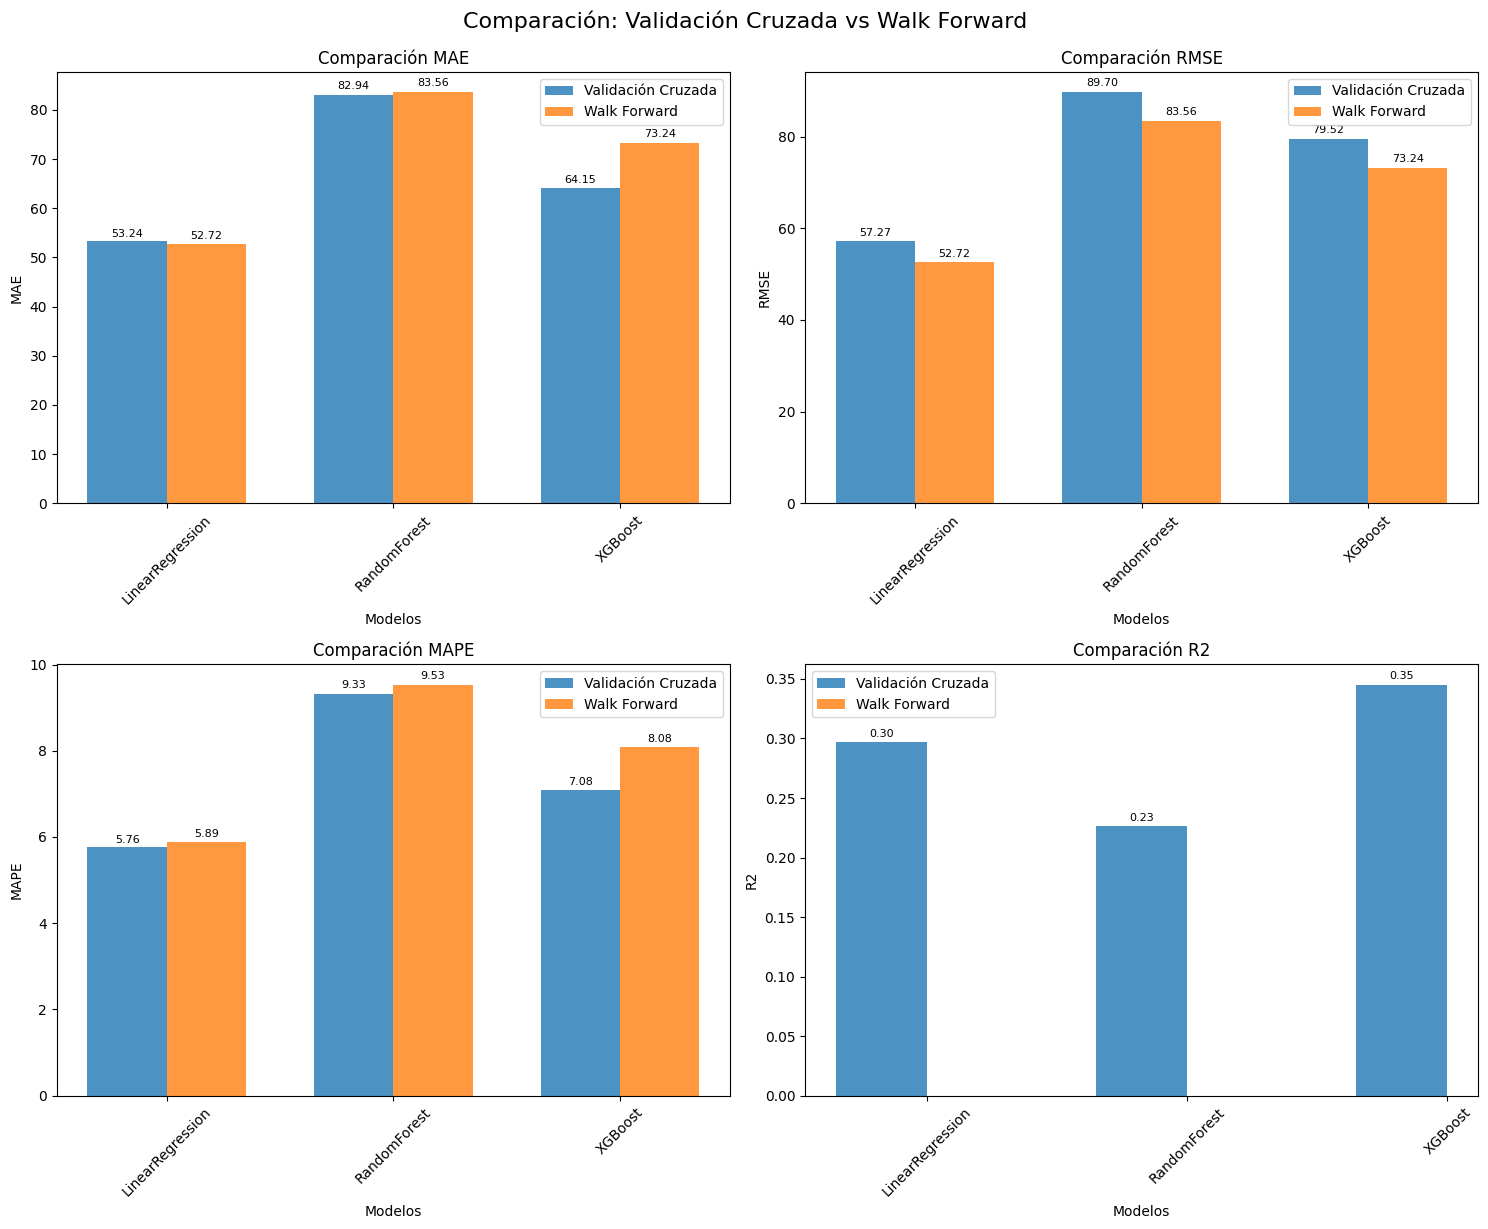

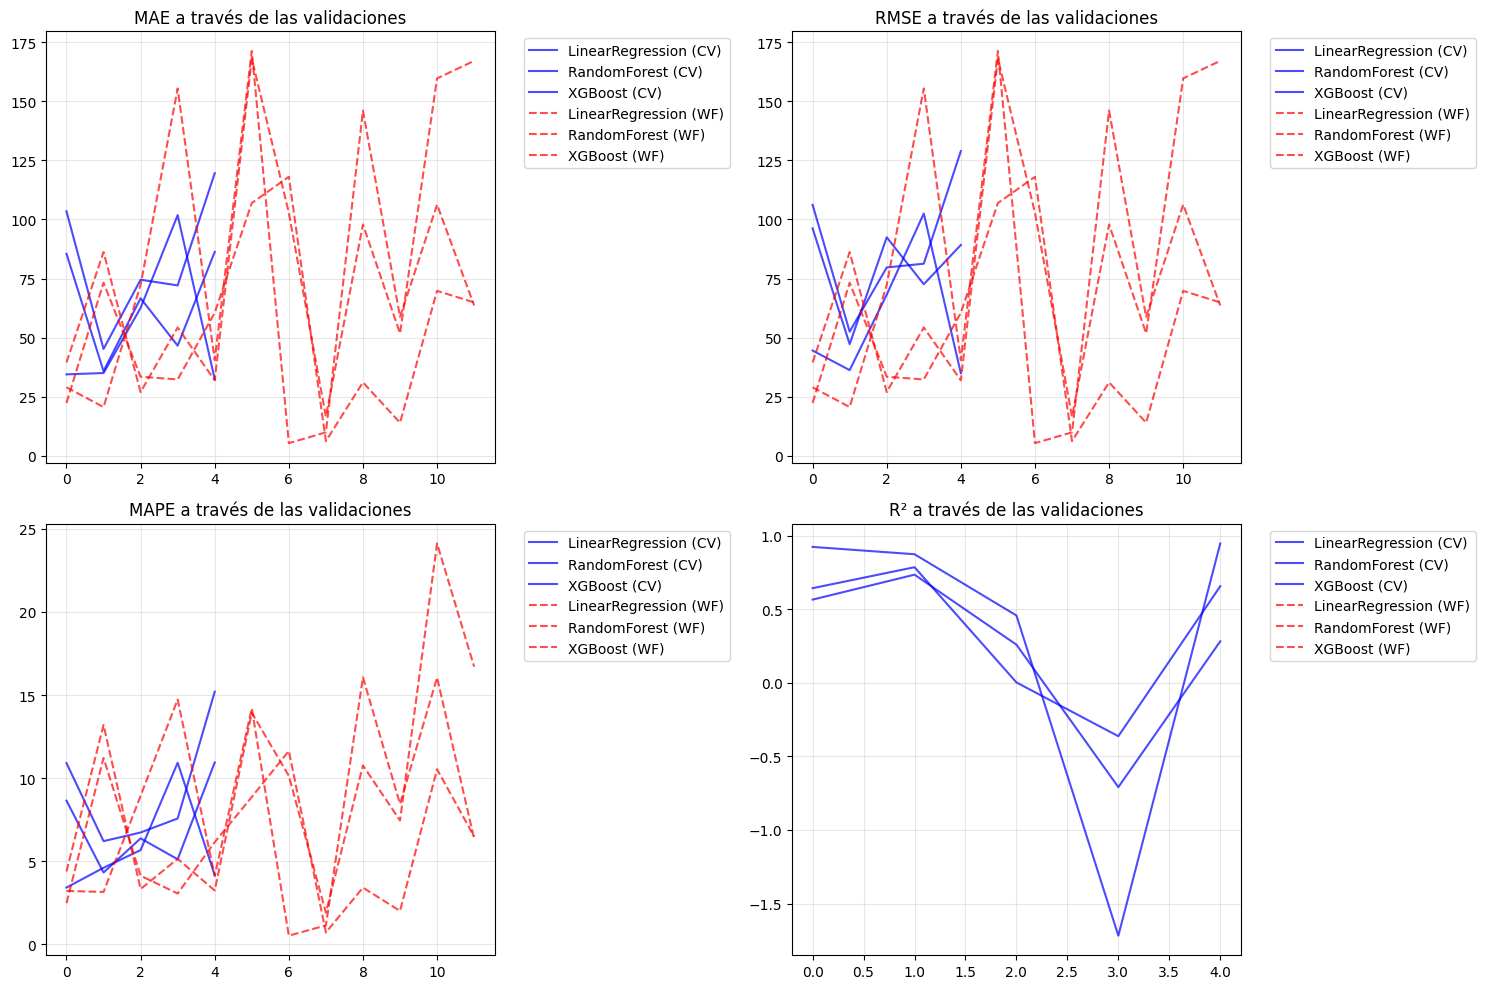


RECOMENDACIONES DE VALIDACIÓN PARA SERIES TEMPORALES

1. VALIDACIÓN CRUZADA TEMPORAL:
   - Útil para evaluación general del modelo
   - Proporciona múltiples estimaciones de rendimiento
   - Mejor para comparar diferentes algoritmos

2. WALK FORWARD VALIDATION:
   - Simula el escenario real de predicción
   - Más conservador y realista
   - Recomendado para selección final del modelo

3. INTERPRETACIÓN:
   - Resultados consistentes entre ambos métodos
   - Modelos son estables y generalizan bien

4. MODELO RECOMENDADO:
   - Basado en Walk Forward: LinearRegression
   - MAE esperado: 52.72
   - RMSE esperado: 52.72



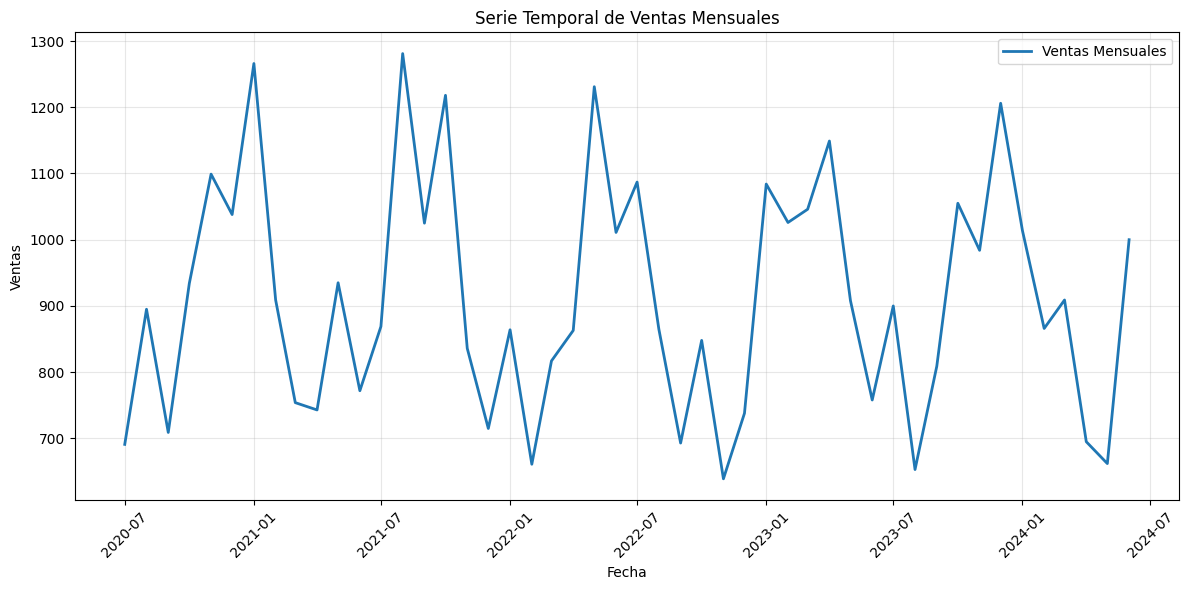

In [45]:
# =============================
# FUNCIONES AUXILIARES PARA PREPARACIÓN DE DATOS
# =============================
def prepare_features(df_base, train_end_idx, test_start_idx, test_end_idx):
    """
    Prepara las características para entrenamiento y prueba con lags y rolling features
    """
    df_train = df_base.iloc[:train_end_idx].copy()
    df_test = df_base.iloc[test_start_idx:test_end_idx].copy()

    # Crear lags
    for lag in range(1, 13):
        df_train[f'lag_{lag}'] = df_train['Sales'].shift(lag)
        # Para test, usar valores conocidos hasta train_end_idx-1
        df_test[f'lag_{lag}'] = np.nan
        for i in range(len(df_test)):
            actual_idx = test_start_idx + i
            lag_idx = actual_idx - lag
            if lag_idx >= 0:
                df_test.iloc[i, df_test.columns.get_loc(f'lag_{lag}')] = df_base['Sales'].iloc[lag_idx]

    # Crear columnas de rolling features primero
    df_train['rolling_mean_3'] = np.nan
    df_train['rolling_mean_6'] = np.nan
    df_train['rolling_std_3'] = np.nan

    df_test['rolling_mean_3'] = np.nan
    df_test['rolling_mean_6'] = np.nan
    df_test['rolling_std_3'] = np.nan

    # Rolling features para train
    df_train['rolling_mean_3'] = df_train['Sales'].rolling(3, min_periods=1).mean()
    df_train['rolling_mean_6'] = df_train['Sales'].rolling(6, min_periods=1).mean()
    df_train['rolling_std_3'] = df_train['Sales'].rolling(3, min_periods=1).std()

    # Para test, calcular rolling usando datos históricos
    for i in range(len(df_test)):
        actual_idx = test_start_idx + i

        # Rolling mean 3
        start_idx = max(0, actual_idx - 3)
        df_test.iloc[i, df_test.columns.get_loc('rolling_mean_3')] = df_base['Sales'].iloc[start_idx:actual_idx].mean()

        # Rolling mean 6
        start_idx = max(0, actual_idx - 6)
        df_test.iloc[i, df_test.columns.get_loc('rolling_mean_6')] = df_base['Sales'].iloc[start_idx:actual_idx].mean()

        # Rolling std 3
        start_idx = max(0, actual_idx - 3)
        std_val = df_base['Sales'].iloc[start_idx:actual_idx].std()
        df_test.iloc[i, df_test.columns.get_loc('rolling_std_3')] = std_val if not np.isnan(std_val) else 0

    return df_train, df_test

def calculate_metrics(y_true, y_pred):
    """
    Calcula métricas de evaluación de forma segura
    """
    try:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # MAPE seguro
        mask = y_true != 0
        if mask.sum() > 0:
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        else:
            mape = np.inf

        r2 = r2_score(y_true, y_pred)

        return mae, rmse, mape, r2
    except:
        return np.nan, np.nan, np.nan, np.nan

# =============================
# VALIDACIÓN CRUZADA TEMPORAL + WALK FORWARD
# =============================
def time_series_cross_validation(df_data, models_dict, n_splits=5, min_train_size=24):
    """
    Implementa validación cruzada temporal para series de tiempo
    """
    print("=== VALIDACIÓN CRUZADA TEMPORAL ===")

    # Preparar datos con features
    df_full = df_data.copy()

    # TimeSeriesSplit con test_size más pequeño
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=3)  # Reducir a 3 meses de test

    cv_results = {name: {'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': []}
                  for name in models_dict.keys()}

    fold = 1
    splits = list(tscv.split(df_full))

    for train_idx, test_idx in splits:
        print(f"Fold {fold}/{n_splits} - Train: {len(train_idx)} meses, Test: {len(test_idx)} meses")

        if len(train_idx) < min_train_size:
            print(f"  Saltando fold {fold}: insuficientes datos de entrenamiento ({len(train_idx)} < {min_train_size})")
            fold += 1
            continue

        try:
            # Preparar datos usando índices correctos
            train_end = train_idx[-1] + 1
            test_start = test_idx[0]
            test_end = test_idx[-1] + 1

            print(f"  Índices - Train: 0 a {train_end-1}, Test: {test_start} a {test_end-1}")

            df_train, df_test = prepare_features(df_full, train_end, test_start, test_end)

            # Limpiar datos
            df_train_clean = df_train.dropna()
            df_test_clean = df_test.fillna(method='ffill').fillna(method='bfill').fillna(0)

            print(f"  Después de limpieza - Train: {len(df_train_clean)} filas, Test: {len(df_test_clean)} filas")

            if len(df_train_clean) < 12:
                print(f"  Saltando fold {fold}: datos insuficientes después de limpiar ({len(df_train_clean)} < 12)")
                fold += 1
                continue

            # Separar features y target
            X_train = df_train_clean.drop(columns=['Sales'])
            y_train = df_train_clean['Sales']
            X_test = df_test_clean.drop(columns=['Sales'])
            y_test = df_test_clean['Sales']

            # Alinear columnas
            missing_cols = set(X_train.columns) - set(X_test.columns)
            for col in missing_cols:
                X_test[col] = 0

            X_test = X_test.reindex(columns=X_train.columns).fillna(0)

            print(f"  Features: {len(X_train.columns)} columnas")

            # Escalar datos
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Entrenar modelos
            for name, model in models_dict.items():
                try:
                    model_clone = clone(model)
                    model_clone.fit(X_train_scaled, y_train)
                    y_pred = model_clone.predict(X_test_scaled)

                    mae, rmse, mape, r2 = calculate_metrics(y_test, y_pred)

                    if not np.isnan(mae):
                        cv_results[name]['MAE'].append(mae)
                        cv_results[name]['RMSE'].append(rmse)
                        cv_results[name]['MAPE'].append(mape)
                        cv_results[name]['R2'].append(r2)
                        print(f"    {name}: MAE={mae:.2f}, R2={r2:.3f}")

                except Exception as e:
                    print(f"    Error en {name}: {e}")

        except Exception as e:
            print(f"  Error en fold {fold}: {e}")

        fold += 1

    return cv_results

def walk_forward_validation(df_data, models_dict, initial_train_size=36):
    """
    Implementa walk forward validation
    """
    print("\n=== WALK FORWARD VALIDATION ===")

    wf_results = {name: {'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': []}
                  for name in models_dict.keys()}

    total_observations = len(df_data)
    predictions_made = 0

    for i in range(initial_train_size, total_observations):
        # Preparar datos
        df_train, df_test = prepare_features(df_data, i, i, i + 1)

        # Limpiar datos
        df_train = df_train.dropna()
        df_test = df_test.fillna(method='ffill').fillna(method='bfill').fillna(0)

        if len(df_train) < 12:
            continue

        # Separar features y target
        X_train = df_train.drop(columns=['Sales'])
        y_train = df_train['Sales']
        X_test = df_test.drop(columns=['Sales'])
        y_test = df_test['Sales']

        # Alinear columnas
        X_test = X_test.reindex(columns=X_train.columns).fillna(0)

        # Escalar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Entrenar y predecir
        for name, model in models_dict.items():
            try:
                model_clone = clone(model)
                model_clone.fit(X_train_scaled, y_train)
                y_pred = model_clone.predict(X_test_scaled)

                mae, rmse, mape, r2 = calculate_metrics(y_test, y_pred)

                if not np.isnan(mae):
                    wf_results[name]['MAE'].append(mae)
                    wf_results[name]['RMSE'].append(rmse)
                    wf_results[name]['MAPE'].append(mape)
                    wf_results[name]['R2'].append(r2)

            except Exception as e:
                continue

        predictions_made += 1

    print(f"Predicciones realizadas: {predictions_made}")
    return wf_results

# =============================
# CONFIGURACIÓN Y EJECUCIÓN
# =============================
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

# Ejecutar validación cruzada temporal
cv_results = time_series_cross_validation(df_model, models, n_splits=5)

# Ejecutar walk forward validation
wf_results = walk_forward_validation(df_model, models)

# =============================
# ANÁLISIS Y COMPARACIÓN DE RESULTADOS
# =============================
def analyze_results(cv_results, wf_results, method_name):
    """
    Analiza y muestra los resultados de validación
    """
    print(f"\n=== RESULTADOS {method_name.upper()} ===")

    results_summary = {}
    for name, metrics in cv_results.items() if method_name == 'CV' else wf_results.items():
        if len(metrics['MAE']) > 0:
            results_summary[name] = {
                'MAE': np.mean(metrics['MAE']),
                'RMSE': np.mean(metrics['RMSE']),
                'MAPE': np.mean(metrics['MAPE']),
                'R2': np.mean(metrics['R2']),
                'MAE_std': np.std(metrics['MAE']),
                'RMSE_std': np.std(metrics['RMSE']),
                'Evaluaciones': len(metrics['MAE'])
            }

    if results_summary:
        results_df = pd.DataFrame(results_summary).T
        print(f"\nMétricas promedio ({method_name}):")
        print(results_df.round(3))

        # Mejor modelo
        best_model = min(results_summary.keys(), key=lambda x: results_summary[x]['MAE'])
        print(f"\nMejor modelo ({method_name}): {best_model}")
        print(f"MAE: {results_summary[best_model]['MAE']:.3f} ± {results_summary[best_model]['MAE_std']:.3f}")
        print(f"RMSE: {results_summary[best_model]['RMSE']:.3f} ± {results_summary[best_model]['RMSE_std']:.3f}")

        return results_summary, best_model
    else:
        print(f"No hay resultados válidos para {method_name}")
        return {}, None

# Analizar resultados de validación cruzada
cv_summary, cv_best = analyze_results(cv_results, None, 'CV')

# Analizar resultados de walk forward
wf_summary, wf_best = analyze_results(None, wf_results, 'Walk Forward')

# =============================
# VISUALIZACIONES COMPARATIVAS
# =============================
def plot_comparative_results(cv_summary, wf_summary):
    """
    Crea visualizaciones comparativas entre métodos de validación
    """
    if not cv_summary or not wf_summary:
        print("Datos insuficientes para visualización comparativa")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    metrics = ['MAE', 'RMSE', 'MAPE', 'R2']
    models = list(cv_summary.keys())

    x = np.arange(len(models))
    width = 0.35

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]

        cv_values = [cv_summary[model][metric] for model in models]
        wf_values = [wf_summary[model][metric] if model in wf_summary else 0 for model in models]

        bars1 = ax.bar(x - width/2, cv_values, width, label='Validación Cruzada', alpha=0.8)
        bars2 = ax.bar(x + width/2, wf_values, width, label='Walk Forward', alpha=0.8)

        ax.set_xlabel('Modelos')
        ax.set_ylabel(metric)
        ax.set_title(f'Comparación {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()

        # Agregar valores sobre las barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.suptitle('Comparación: Validación Cruzada vs Walk Forward', y=1.02, fontsize=16)
    plt.show()

def plot_validation_stability(cv_results, wf_results):
    """
    Muestra la estabilidad de las métricas a través de las validaciones
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    methods = [('CV', cv_results), ('WF', wf_results)]
    colors = ['blue', 'red']

    for method_idx, (method_name, results) in enumerate(methods):
        if not results:
            continue

        for model_name, metrics in results.items():
            if len(metrics['MAE']) == 0:
                continue

            # MAE over time
            axes[0, 0].plot(metrics['MAE'], label=f'{model_name} ({method_name})',
                           color=colors[method_idx], alpha=0.7,
                           linestyle='-' if method_idx == 0 else '--')

            # RMSE over time
            axes[0, 1].plot(metrics['RMSE'], label=f'{model_name} ({method_name})',
                           color=colors[method_idx], alpha=0.7,
                           linestyle='-' if method_idx == 0 else '--')

            # MAPE over time
            mape_clean = [x for x in metrics['MAPE'] if not np.isinf(x) and not np.isnan(x)]
            if mape_clean:
                axes[1, 0].plot(mape_clean, label=f'{model_name} ({method_name})',
                               color=colors[method_idx], alpha=0.7,
                               linestyle='-' if method_idx == 0 else '--')

            # R2 over time
            axes[1, 1].plot(metrics['R2'], label=f'{model_name} ({method_name})',
                           color=colors[method_idx], alpha=0.7,
                           linestyle='-' if method_idx == 0 else '--')

    titles = ['MAE a través de las validaciones', 'RMSE a través de las validaciones',
              'MAPE a través de las validaciones', 'R² a través de las validaciones']

    for i, ax in enumerate(axes.flat):
        ax.set_title(titles[i])
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Crear visualizaciones
plot_comparative_results(cv_summary, wf_summary)
plot_validation_stability(cv_results, wf_results)

# =============================
# RECOMENDACIONES FINALES
# =============================
print("\n" + "="*60)
print("RECOMENDACIONES DE VALIDACIÓN PARA SERIES TEMPORALES")
print("="*60)

print("\n1. VALIDACIÓN CRUZADA TEMPORAL:")
print("   - Útil para evaluación general del modelo")
print("   - Proporciona múltiples estimaciones de rendimiento")
print("   - Mejor para comparar diferentes algoritmos")

print("\n2. WALK FORWARD VALIDATION:")
print("   - Simula el escenario real de predicción")
print("   - Más conservador y realista")
print("   - Recomendado para selección final del modelo")

print("\n3. INTERPRETACIÓN:")
if cv_summary and wf_summary:
    cv_best_mae = min([cv_summary[m]['MAE'] for m in cv_summary.keys()])
    wf_best_mae = min([wf_summary[m]['MAE'] for m in wf_summary.keys()])

    if wf_best_mae > cv_best_mae * 1.2:
        print("   - Walk Forward muestra rendimiento significativamente peor")
        print("   - Posible sobreajuste detectado en validación cruzada")
        print("   - Recomendación: usar métricas de Walk Forward para decisiones")
    else:
        print("   - Resultados consistentes entre ambos métodos")
        print("   - Modelos son estables y generalizan bien")

print(f"\n4. MODELO RECOMENDADO:")
if wf_best:
    print(f"   - Basado en Walk Forward: {wf_best}")
    if wf_summary:
        print(f"   - MAE esperado: {wf_summary[wf_best]['MAE']:.2f}")
        print(f"   - RMSE esperado: {wf_summary[wf_best]['RMSE']:.2f}")

print("\n" + "="*60)

# =============================
# Visualización de los datos originales
# =============================
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['Sales'], label='Ventas Mensuales', linewidth=2)
plt.title('Serie Temporal de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de Resultados

#### 🧪 Comparación de Resultados: Validación Cruzada vs. Walk Forward

**Validación Cruzada Temporal (CV)**:

| Modelo           | MAE   | RMSE  | MAPE (%) | R²    |
| ---------------- | ----- | ----- | -------- | ----- |
| LinearRegression | 53.24 | 57.27 | 5.76     | 0.297 |
| RandomForest     | 82.94 | 89.70 | 9.33     | 0.227 |
| XGBoost          | 64.15 | 79.53 | 7.08     | 0.345 |

**Walk Forward Validation (WF)**:

| Modelo           | MAE   | RMSE  | MAPE (%) | R²  |
| ---------------- | ----- | ----- | -------- | --- |
| LinearRegression | 52.72 | 52.72 | 5.89     | N/A |
| RandomForest     | 83.56 | 83.56 | 9.53     | N/A |
| XGBoost          | 73.24 | 73.24 | 8.08     | N/A |

#### Interpretación

* **Consistencia del mejor modelo**: LinearRegression fue el mejor tanto en CV como en WF. Esto muestra **robustez y generalización**, aún siendo un modelo simple.
* **Rendimiento del modelo en producción**: Las métricas de Walk Forward son ligeramente peores que en CV, pero **coherentes**, lo cual indica bajo riesgo de sobreajuste.
* **Modelos complejos no aportan valor adicional** en este caso (RF y XGB presentan mayor error y menor estabilidad). Posiblemente el fenómeno de ventas está dominado por tendencias lineales y efectos agregados.
* **MAPE bajo (<6%)** en LinearRegression en ambos métodos. Esto indica que **los errores de predicción son pequeños en proporción a las ventas reales**.
* **Variabilidad en los errores**: El alto desvío estándar en RF y XGBoost sugiere sensibilidad a la muestra de entrenamiento.

---

### Conclusiones del Análisis

1. El modelo de regresión lineal **presenta el menor error absoluto promedio (MAE)** y la **mayor estabilidad en el tiempo**, lo cual lo convierte en la mejor opción para implementación.
2. La técnica de **walk forward valida adecuadamente el comportamiento del modelo ante nuevos datos**, simulando la producción.
3. Los modelos más complejos **no mejoran el rendimiento** y presentan mayor inestabilidad, posiblemente por escasa cantidad de observaciones o por relaciones no lineales poco relevantes.
4. Los resultados sugieren que la serie de ventas **responde más a patrones estacionales, de tendencia y a eventos clave** (ej. campañas, clima, lanzamientos) que a interacciones complejas entre variables.
5. La tasa de error relativa (MAPE) está por debajo del 6%, lo cual es **aceptable para decisiones operativas y de marketing**.

---

### Estrategias de Marketing Derivadas del Modelo

Con base en la capacidad de predicción obtenida y la estructura del modelo, se pueden tomar las siguientes decisiones estratégicas:

### 1. 📅 **Planificación de campañas más eficientes**

* Activar campañas **con base en proyecciones de baja demanda**, redirigiendo presupuesto hacia periodos que lo necesiten más.
* Ajustar la **intensidad publicitaria** por mes anticipadamente, reduciendo costos sin comprometer ventas.

### 2. 🎁 **Optimización de promociones y lanzamientos**

* Programar **lanzamientos de productos** en momentos con caída esperada de ventas para estimular el consumo.
* Evaluar campañas de **Black Friday o Festivos Nacionales** desde la perspectiva de retorno esperado, contrastando con el baseline del modelo.

### 3. 🛒 **Gestión de inventarios y logística**

* Compartir las predicciones con el equipo de supply chain para evitar quiebres de stock o sobreacumulación.
* Usar pronósticos como insumo para el modelo de abastecimiento.

### 4. 🧲 **Segmentación por tipo de canal o cliente (futuro)**

* Si se incluye desagregación por canal (web, físico, catálogo), se puede personalizar promociones y esfuerzos de fidelización según los picos esperados de ventas por canal.
* Reforzar estrategias de cross-selling en momentos de alta recurrencia esperada.

### 5. 📉 **Revisión de canales de bajo impacto**

* Si las campañas no logran alterar el comportamiento previsto por el modelo (ventas similares con o sin campaña), se puede optimizar la asignación de presupuesto a canales más efectivos.

---